In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import pytorch_lightning as pl
import torch
from datetime import timedelta
from pytorch_forecasting import Baseline, GroupNormalizer, MultiNormalizer, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data.encoders import NaNLabelEncoder, TorchNormalizer
from pytorch_forecasting.metrics import QuantileLoss, SMAPE, MAPE, MAE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from tqdm import tqdm

%matplotlib inline

/home/user/conda/lib/python3.7/site-packages/pytorch_lightning/metrics/__init__.py:44: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  "`pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package"
/home/user/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/iterator_ops.py:546: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class IteratorBase(collections.Iterator, trackable.Trackable,
/home/user/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:106: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  cl

# Preprocessing

In [2]:
%%time

df = pd.read_csv("data/data_preprocessed.csv")
df

CPU times: user 14.6 ms, sys: 15.8 ms, total: 30.4 ms
Wall time: 30.5 ms


,Регион,Имя теста,date_day,sum,count
0,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2019-07-30,0,1
1,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2020-04-25,0,1
2,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2020-05-19,0,2
3,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2020-08-01,0,1
4,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-05-11,0,1
...,...,...,...,...,...
23464,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,2021-05-29,0,2
23465,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,2021-05-31,0,3
23466,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,2021-06-03,0,2
23467,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,2021-06-04,0,1


In [3]:
regions_count_max = df.groupby(['Регион', 'Имя теста'])['count'].max().reset_index()
regions_count_max

,Регион,Имя теста,count
0,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2
1,Адыгея Респ,Вирус клещевого энцефалита(кач) РНК,1
2,Алтай Респ,Anaplasma Phagocytophillum(кач) ДНК,2
3,Алтай Респ,Borrelia burgdorferi s.l (кач) ДНК,2
4,Алтай Респ,Ehrlichia muris/chaffeеnsis(кач) ДНК,2
...,...,...,...
181,Чувашская Респ,Вирус клещевого энцефалита(кач) РНК,3
182,Ямало-Ненецкий АО,Borrelia burgdorferi s.l (кач) ДНК,1
183,Ямало-Ненецкий АО,Вирус клещевого энцефалита(кач) РНК,1
184,Ярославская обл,Borrelia burgdorferi s.l (кач) ДНК,4


In [4]:
df = pd.merge(df, regions_count_max, left_on=['Регион', 'Имя теста'], right_on=['Регион', 'Имя теста'])
df.rename(columns={'count_y': 'count_max'}, inplace=True)
df['percent_count'] = df['count_x'] / df['count_max']
df

,Регион,Имя теста,date_day,sum,count_x,count_max,percent_count
0,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2019-07-30,0,1,2,0.50
1,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2020-04-25,0,1,2,0.50
2,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2020-05-19,0,2,2,1.00
3,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2020-08-01,0,1,2,0.50
4,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-05-11,0,1,2,0.50
...,...,...,...,...,...,...,...
23464,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,2021-05-29,0,2,4,0.50
23465,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,2021-05-31,0,3,4,0.75
23466,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,2021-06-03,0,2,4,0.50
23467,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,2021-06-04,0,1,4,0.25


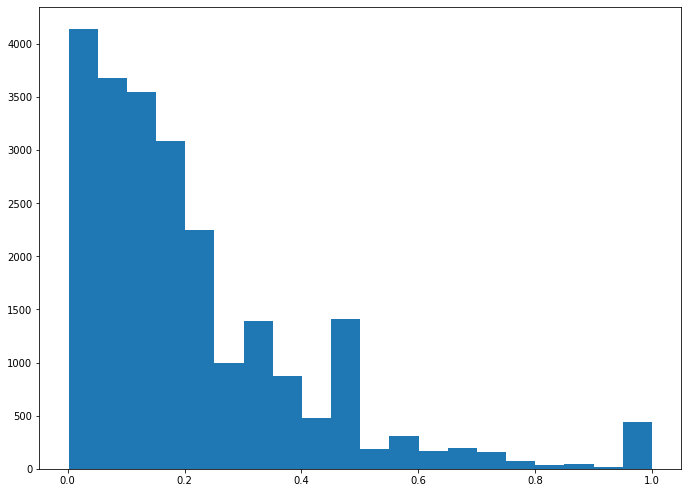

In [5]:
plt.figure(figsize=(11.5, 8.5))
plt.hist(df['percent_count'], bins=20)
plt.show()

In [6]:
df["date_day"] = pd.to_datetime(df["date_day"])
df["date_day"].min(), df["date_day"].max()

(Timestamp('2019-02-13 00:00:00'), Timestamp('2021-06-09 00:00:00'))

In [7]:
df.isnull().sum()

Регион           0
Имя теста        0
date_day         0
sum              0
count_x          0
count_max        0
percent_count    0
dtype: int64

In [8]:
date_min = df["date_day"].min()
df['time_idx'] = df["date_day"].apply(lambda x: (x - date_min).days)

df["Номер месяца"] = df["date_day"].dt.month.astype(str).astype('category')
df["День недели"] = df["date_day"].dt.weekday.astype(str).astype('category')
df

,Регион,Имя теста,date_day,sum,count_x,count_max,percent_count,time_idx,Номер месяца,День недели
0,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2019-07-30,0,1,2,0.50,167,7,1
1,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2020-04-25,0,1,2,0.50,437,4,5
2,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2020-05-19,0,2,2,1.00,461,5,1
3,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2020-08-01,0,1,2,0.50,535,8,5
4,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-05-11,0,1,2,0.50,818,5,1
...,...,...,...,...,...,...,...,...,...,...
23464,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,2021-05-29,0,2,4,0.50,836,5,5
23465,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,2021-05-31,0,3,4,0.75,838,5,0
23466,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,2021-06-03,0,2,4,0.50,841,6,3
23467,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,2021-06-04,0,1,4,0.25,842,6,4


In [9]:
TEST_PERIOD = timedelta(days=14)
CUT_DATE = df["date_day"].max() - TEST_PERIOD
CUT_DATE

Timestamp('2021-05-26 00:00:00')

In [10]:
df_train = df[df["date_day"] <= CUT_DATE].reset_index(drop=True)
df_test = df[df["date_day"] > CUT_DATE].reset_index(drop=True)
df_train.shape, df_test.shape

((22240, 10), (1229, 10))

# Dataset creation

In [11]:
df_train.dtypes

Регион                   object
Имя теста                object
date_day         datetime64[ns]
sum                       int64
count_x                   int64
count_max                 int64
percent_count           float64
time_idx                  int64
Номер месяца           category
День недели            category
dtype: object

In [12]:
STATIC_CATEGORICALS = [
    'Регион', 'Имя теста'
]
STATIC_REALS = []
KNOWN_CATEGORICALS = ['Номер месяца', 'День недели']
KNOWN_REALS = ['time_idx']
UNKNOWN_REALS = ['percent_count']

In [13]:
df

,Регион,Имя теста,date_day,sum,count_x,count_max,percent_count,time_idx,Номер месяца,День недели
0,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2019-07-30,0,1,2,0.50,167,7,1
1,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2020-04-25,0,1,2,0.50,437,4,5
2,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2020-05-19,0,2,2,1.00,461,5,1
3,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2020-08-01,0,1,2,0.50,535,8,5
4,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-05-11,0,1,2,0.50,818,5,1
...,...,...,...,...,...,...,...,...,...,...
23464,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,2021-05-29,0,2,4,0.50,836,5,5
23465,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,2021-05-31,0,3,4,0.75,838,5,0
23466,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,2021-06-03,0,2,4,0.50,841,6,3
23467,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,2021-06-04,0,1,4,0.25,842,6,4


In [14]:
training = TimeSeriesDataSet(
    df_train,
    time_idx="time_idx",
    target="percent_count",
    group_ids=["Регион", "Имя теста"],
    min_encoder_length=1,
    max_encoder_length=7*4,
    min_prediction_length=1,
    max_prediction_length=1,
    static_categoricals=STATIC_CATEGORICALS,
    static_reals=STATIC_REALS,
    time_varying_known_categoricals=KNOWN_CATEGORICALS,
    time_varying_known_reals=KNOWN_REALS,
    time_varying_unknown_reals=UNKNOWN_REALS,
    constant_fill_strategy={'percent_count': 0.0},
    allow_missing_timesteps=True,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    categorical_encoders={ft: NaNLabelEncoder(add_nan=True) for ft in KNOWN_CATEGORICALS},
    target_normalizer=GroupNormalizer(
        groups=["Регион", "Имя теста"], transformation="softplus"
    )
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(
    training,
    df, # on inference, set df[df["Дата заказа"] <= INFERENCE_DATE]
#     min_encoder_length=7*10,
    min_prediction_idx=int(df_test['time_idx'].min()),
    predict=False, # on inference, set predict=True
    stop_randomization=True,
)

# create dataloaders for model
batch_size = 512  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=48, pin_memory=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=48, pin_memory=True)
print(f'Train dataset length: {len(training)}, train dataloader length: {len(train_dataloader)}')
print(f'Val dataset length: {len(validation)}, val dataloader length: {len(val_dataloader)}')

/home/user/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:121: UserWarning: Found 12 unknown classes which were set to NaN
  UserWarning,
/home/user/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:121: UserWarning: Found 7 unknown classes which were set to NaN
  UserWarning,
/home/user/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:621: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/home/user/conda/lib/python3.7/site-packages/pytorch_forecasting/data/timeseries.py:1244: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 14 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__Регион': 'Еврейская АО', '__group_id__Имя теста': 'Borrelia burgdorferi s.l

Train dataset length: 29581, train dataloader length: 57
Val dataset length: 3814, val dataloader length: 8


/home/user/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:121: UserWarning: Found 3 unknown classes which were set to NaN
  UserWarning,
/home/user/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:121: UserWarning: Found 7 unknown classes which were set to NaN
  UserWarning,
/home/user/conda/lib/python3.7/site-packages/pytorch_forecasting/data/timeseries.py:1244: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 19 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__Регион': 'Астраханская обл', '__group_id__Имя теста': 'Borrelia burgdorferi s.l (кач) ДНК'}, {'__group_id__Регион': 'Астраханская обл', '__group_id__Имя теста': 'Вирус клещевого энцефалита(кач) РНК'}, {'__group_id__Регион': 'Дагестан Респ', '__group_id__Имя теста': 'Borrelia burgdorferi s.l (кач) ДНК'},

In [15]:
training.decoded_index

,Регион,Имя теста,time_idx_first,time_idx_last,time_idx_first_prediction
0,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,437,461,461
1,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,818,829,829
2,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,827,829,829
3,Адыгея Респ,Вирус клещевого энцефалита(кач) РНК,535,551,551
4,Адыгея Респ,Вирус клещевого энцефалита(кач) РНК,813,829,829
...,...,...,...,...,...
29576,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,791,815,815
29577,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,794,821,821
29578,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,800,826,826
29579,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,800,827,827


In [16]:
validation.decoded_index

,Регион,Имя теста,time_idx_first,time_idx_last,time_idx_first_prediction
0,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,818,844,844
1,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,827,844,844
2,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,829,844,844
3,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,836,844,844
4,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,839,844,844
...,...,...,...,...,...
3809,Ярославская обл,Borrelia burgdorferi s.l (кач) ДНК,815,842,842
3810,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,812,835,835
3811,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,812,836,836
3812,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,812,838,838


In [17]:
sorted(validation.decoded_index['time_idx_last'].unique()), len(sorted(validation.decoded_index['time_idx_last'].unique()))

([834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847], 14)

In [18]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mae_rounded = mean_absolute_error(y_true, y_pred.round())
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mape_rounded = mean_absolute_percentage_error(y_true, y_pred.round())
    smape = SMAPE()(y_true, y_pred).item()
    smape_rounded = SMAPE()(y_true, y_pred.round()).item()
    print(f'MAE: {mae:.4f}, rounded: {mae_rounded:.4f}')
    print(f'MAPE: {mape:.4f}, rounded: {mape_rounded:.4f}')
    print(f'SMAPE: {smape:.4f}, rounded: {smape_rounded:.4f}')

In [19]:
print('Baseline predictions')
actuals = torch.cat([y for x, (y, _) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
calculate_metrics(actuals, baseline_predictions)

Baseline predictions
MAE: 0.2197, rounded: 0.3006
MAPE: 2.2283, rounded: 1.9785
SMAPE: 0.9441, rounded: 1.8957


In [20]:
inference_idx = validation.decoded_index[validation.decoded_index['time_idx_last'] == 847].index
len(inference_idx)

1061

In [21]:
calculate_metrics(actuals[inference_idx], baseline_predictions[inference_idx])

MAE: 0.2595, rounded: 0.1881
MAPE: 6.1480, rounded: 3.8737
SMAPE: 1.1776, rounded: 1.9480


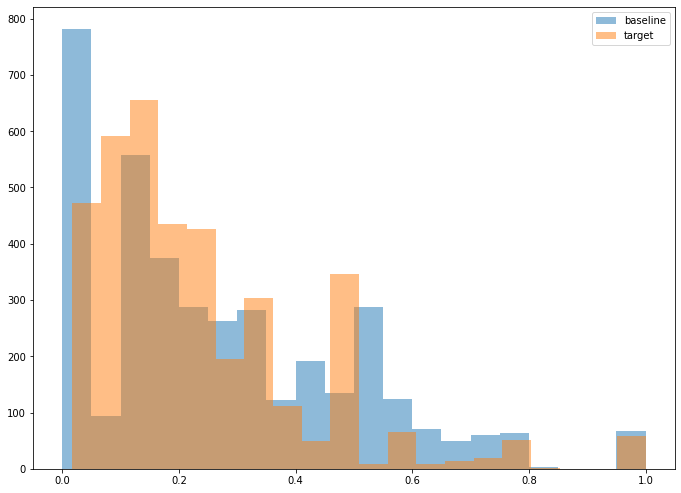

In [22]:
plt.figure(figsize=(11.5, 8.5))
plt.hist(baseline_predictions.numpy().ravel(), bins=20, alpha=0.5, label='baseline')
plt.hist(actuals.numpy().ravel(), bins=20, alpha=0.5, label='target')
plt.legend(loc='best')
plt.show()

# Training

In [23]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-7, patience=20, verbose=False, mode="min")

# try:
#     lighting_logs_folder = f"logs-{environment}-{cfg.exp_name}"
# except:
#     lighting_logs_folder = f"logs-jupyter"
lighting_logs_folder = 'lightning_logs_percent_count'
lightning_logs_name = 'v03-mae-min_encoder_length-1'

pathlib.Path(os.path.join(lighting_logs_folder, lightning_logs_name)).mkdir(parents=True, exist_ok=True)

logger = TensorBoardLogger(lighting_logs_folder, name=lightning_logs_name)  # logging results to a tensorboard
print(f"TensorBoardLogger to {lighting_logs_folder}/{lightning_logs_name}")
lr_monitor = LearningRateMonitor(logging_interval='step')

# configure network and trainer
pl.seed_everything(13)
trainer = pl.Trainer(
    gpus=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.5,
#     accumulate_grad_batches=4,
    max_epochs=1000,
    stochastic_weight_avg=True,
    callbacks=[early_stop_callback, lr_monitor],
    logger=logger
)

#     trainer = pl.Trainer(**cfg.trainer,
#                          callbacks=[early_stop_callback, lr_monitor],
#                          logger=logger
#                         )

tft = TemporalFusionTransformer.from_dataset(
    training,
#     weight_decay=0.1,
    learning_rate=0.001,
    hidden_size=8,
    lstm_layers=2,
    attention_head_size=4,
    dropout=0.3,
    hidden_continuous_size=8,
    output_size=1,
    loss=MAE()
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 13
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


TensorBoardLogger to lightning_logs_percent_count/v03-mae-min_encoder_length-1
Number of parameters in network: 9.1k


In [ ]:
%%time
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 687   
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.3 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.3 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 916   
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304   
9  | static_context_initial_cell_lstm 

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 13


Training: 0it [00:00, ?it/s]

/home/user/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/callback_hook.py:101: LightningDeprecationWarning: The signature of `Callback.on_train_epoch_end` has changed in v1.3. `outputs` parameter has been removed. Support for the old signature will be removed in v1.5
  "The signature of `Callback.on_train_epoch_end` has changed in v1.3."


Validating: 0it [00:00, ?it/s]

/home/user/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  "Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2"


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

# Results

In [25]:
trainer.checkpoint_callback.best_model_path

'lightning_logs_percent_count/v03-mae-min_encoder_length-1/version_0/checkpoints/epoch=49-step=2849.ckpt'

In [26]:
# best_model_path = trainer.checkpoint_callback.best_model_path
best_model_path = 'lightning_logs_percent_count/v03-mae-min_encoder_length-1/version_0/checkpoints/epoch=49-step=2849.ckpt'
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path).cuda()

In [27]:
%%time

print('TFT predictions')
# actuals = torch.cat([y for x, (y, _) in iter(val_dataloader)])
tft_predictions = best_tft.predict(val_dataloader)
calculate_metrics(actuals, tft_predictions)

TFT predictions
MAE: 0.1273, rounded: 0.2379
MAPE: 1.1356, rounded: 0.9992
SMAPE: 0.5887, rounded: 1.9733
CPU times: user 1.4 s, sys: 7.13 s, total: 8.53 s
Wall time: 24 s


In [32]:
tft_predictions_cut = torch.clone(tft_predictions)
tft_predictions_cut[np.where(tft_predictions_cut > 1)[0], :] = 1
calculate_metrics(actuals, tft_predictions_cut)

MAE: 0.1184, rounded: 0.2300
MAPE: 1.1268, rounded: 0.9913
SMAPE: 0.5830, rounded: 1.9680


In [29]:
calculate_metrics(actuals[inference_idx], tft_predictions[inference_idx])

MAE: 0.0897, rounded: 0.0865
MAPE: 2.6215, rounded: 1.0000
SMAPE: 0.8241, rounded: 2.0000


In [30]:
calculate_metrics(actuals[inference_idx], tft_predictions_cut[inference_idx])

MAE: 0.0897, rounded: 0.0865
MAPE: 2.6215, rounded: 1.0000
SMAPE: 0.8241, rounded: 2.0000


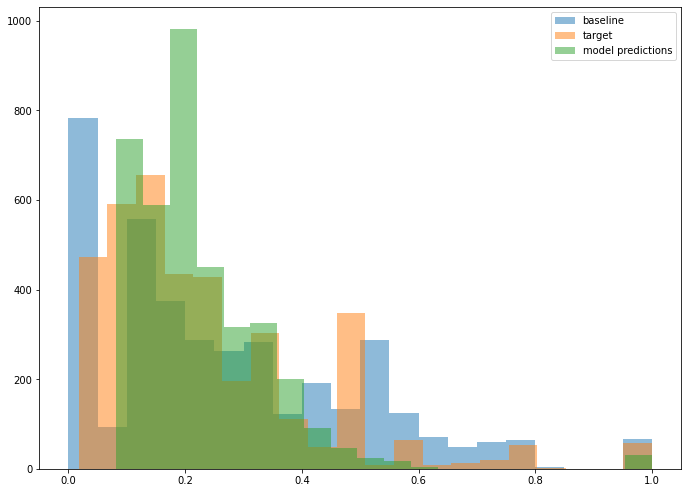

In [31]:
plt.figure(figsize=(11.5, 8.5))
plt.hist(baseline_predictions.numpy().ravel(), bins=20, alpha=0.5, label='baseline')
plt.hist(actuals.numpy().ravel(), bins=20, alpha=0.5, label='target')
plt.hist(tft_predictions_cut.numpy().ravel(), bins=20, alpha=0.5, label='model predictions')
plt.legend(loc='best')
plt.show()

# Inference

In [35]:
INFERENCE_PREDICTION_LENGTH = 19
MAX_ENCODER_LENGTH = 28
INFERENCE_MIN_PREDICTION_IDX = 848
INFERENCE_DATES = pd.date_range('2021-06-09', '2021-06-27')
INFERENCE_MONTH = pd.Series([6] * INFERENCE_PREDICTION_LENGTH).astype(str).astype('category')
INFERENCE_WEEKDAY = pd.Series([x.weekday() for x in pd.date_range('2021-06-09', '2021-06-27')]).astype(str).astype('category')
INFERENCE_TIME_IDX = pd.Series(np.arange(INFERENCE_MIN_PREDICTION_IDX, INFERENCE_MIN_PREDICTION_IDX + INFERENCE_PREDICTION_LENGTH))

test_cols = [
    'Anaplasma Phagocytophillum(кач) ДНК',
    'Borrelia burgdorferi s.l (кач) ДНК',
    'Borrelia miyamotoi (кач) ДНК',
    'Ehrlichia muris/chaffeеnsis(кач) ДНК',
    'Вирус клещевого энцефалита(кач) РНК'
]

regions = sorted(df['Регион'].unique())
print('Total regions:', len(regions))
regions_submission_column = []
dates_submission_column = []
for r in regions:
    regions_submission_column += [r] * INFERENCE_PREDICTION_LENGTH
    dates_submission_column += INFERENCE_DATES

Total regions: 67


In [36]:
df_submission = pd.DataFrame({'region': regions_submission_column}, index=dates_submission_column)
df_submission

,region
2021-06-09,Адыгея Респ
2021-06-10,Адыгея Респ
2021-06-11,Адыгея Респ
2021-06-12,Адыгея Респ
2021-06-13,Адыгея Респ
...,...
2021-06-23,Ярославская обл
2021-06-24,Ярославская обл
2021-06-25,Ярославская обл
2021-06-26,Ярославская обл


In [37]:
import warnings
warnings.filterwarnings('ignore')

In [39]:
errors = []
for test in test_cols:
    for region in tqdm(regions):
        df_region_test = df[(df['Регион'] == region) & (df['Имя теста'] == test)]
        if len(df_region_test) > 0:
            encoder_data = df_region_test[lambda x: x.time_idx > INFERENCE_MIN_PREDICTION_IDX - 1 - MAX_ENCODER_LENGTH]
            decoder_data = pd.DataFrame({
                'Регион': [region] * INFERENCE_PREDICTION_LENGTH,
                'Имя теста': [test] * INFERENCE_PREDICTION_LENGTH,
                'date_day': INFERENCE_DATES,
                'percent_count': 0.0,
                'time_idx': INFERENCE_TIME_IDX,
                'Номер месяца': INFERENCE_MONTH,
                'День недели': INFERENCE_WEEKDAY
            })
            new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)
            one_pair = TimeSeriesDataSet.from_dataset(
                validation,
                new_prediction_data,
                stop_randomization=True,
                min_encoder_length=int(INFERENCE_MIN_PREDICTION_IDX - new_prediction_data['time_idx'].min()),
                min_prediction_idx=INFERENCE_MIN_PREDICTION_IDX,
                min_prediction_length=INFERENCE_PREDICTION_LENGTH,
                max_prediction_length=INFERENCE_PREDICTION_LENGTH
            )
            one_pair_dataloader = one_pair.to_dataloader(train=False, batch_size=1, num_workers=0)
            if len(one_pair_dataloader) != 1:
                errors.append((region, test, len(one_pair_dataloader)))
            predictions_one_pair = best_tft.predict(one_pair_dataloader).numpy().ravel()
            df_submission.loc[df_submission['region'] == region, test + ' percent_count'] = predictions_one_pair
        else:
            df_submission.loc[df_submission['region'] == region, test + ' percent_count'] = 0.0
print('Errors:')
print(errors)

100%|██████████| 67/67 [00:14<00:00,  4.74it/s]

Errors:
[]


In [66]:
df_submission

,region,Anaplasma Phagocytophillum(кач) ДНК percent_count,Borrelia burgdorferi s.l (кач) ДНК percent_count,Borrelia miyamotoi (кач) ДНК percent_count,Ehrlichia muris/chaffeеnsis(кач) ДНК percent_count,Вирус клещевого энцефалита(кач) РНК percent_count
2021-06-09,Адыгея Респ,0.0,0.403034,0.0,0.0,2.126928
2021-06-10,Адыгея Респ,0.0,0.350178,0.0,0.0,2.126928
2021-06-11,Адыгея Респ,0.0,0.402199,0.0,0.0,2.126928
2021-06-12,Адыгея Респ,0.0,0.393943,0.0,0.0,2.126928
2021-06-13,Адыгея Респ,0.0,0.400322,0.0,0.0,2.126928
...,...,...,...,...,...,...
2021-06-23,Ярославская обл,0.0,0.312065,0.0,0.0,0.320502
2021-06-24,Ярославская обл,0.0,0.302632,0.0,0.0,0.310614
2021-06-25,Ярославская обл,0.0,0.308432,0.0,0.0,0.316783
2021-06-26,Ярославская обл,0.0,0.306163,0.0,0.0,0.314524


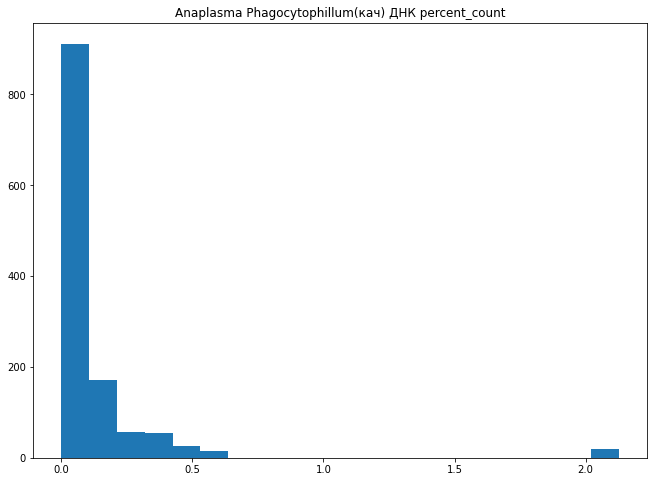

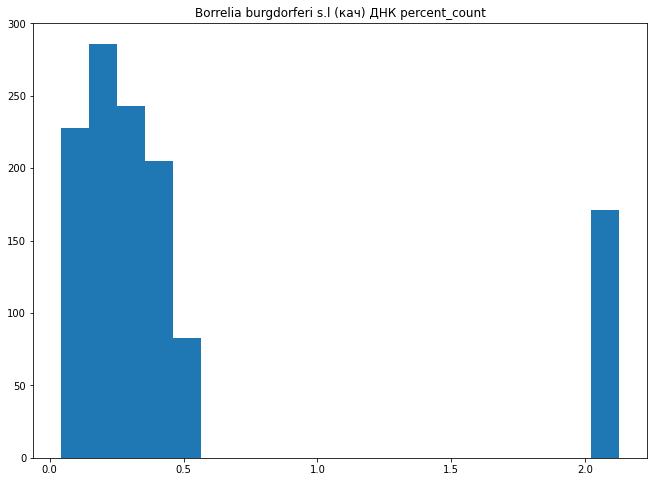

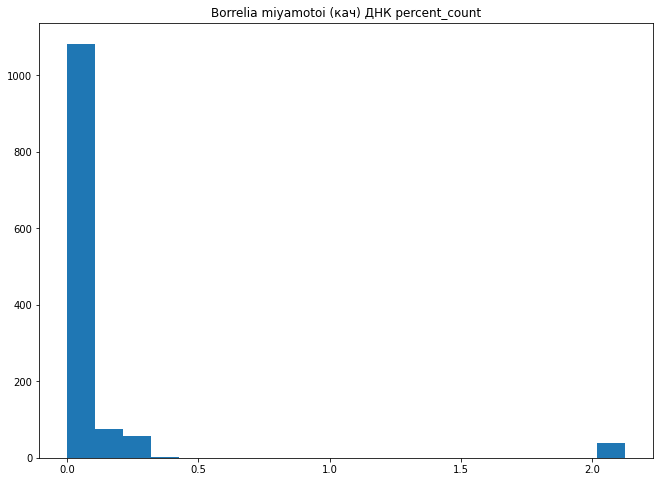

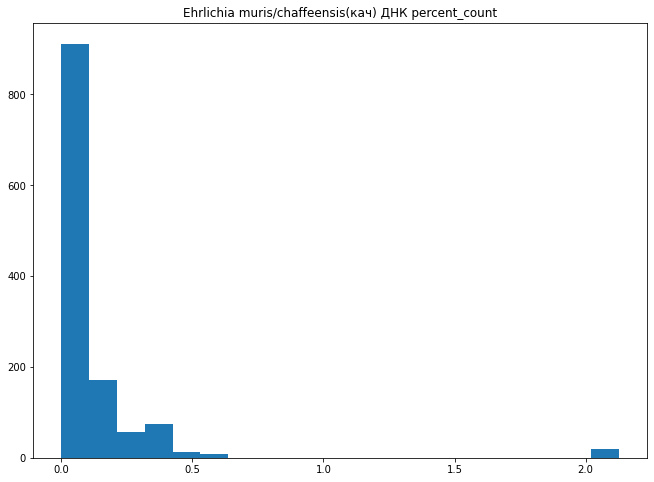

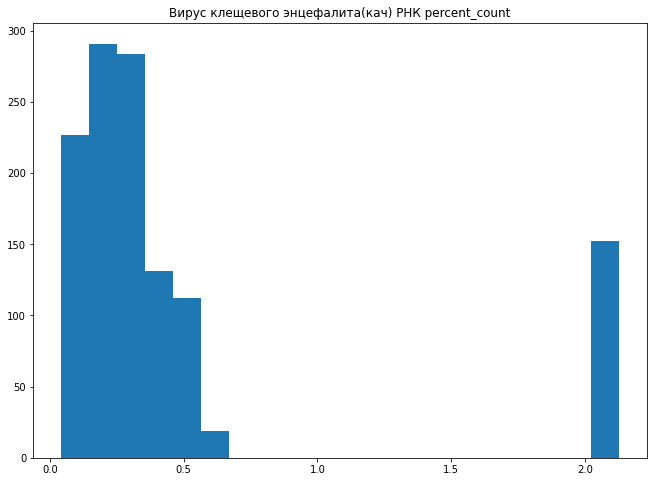

In [67]:
for col in df_submission.columns[1:]:
    plt.figure(figsize=(11, 8))
    plt.hist(df_submission[col], bins=20)
    plt.title(col)
    plt.show()

In [68]:
df_regions_max = df.groupby(['Регион', 'Имя теста'])['count_max'].max().reset_index()
df_regions_max

,Регион,Имя теста,count_max
0,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2
1,Адыгея Респ,Вирус клещевого энцефалита(кач) РНК,1
2,Алтай Респ,Anaplasma Phagocytophillum(кач) ДНК,2
3,Алтай Респ,Borrelia burgdorferi s.l (кач) ДНК,2
4,Алтай Респ,Ehrlichia muris/chaffeеnsis(кач) ДНК,2
...,...,...,...
181,Чувашская Респ,Вирус клещевого энцефалита(кач) РНК,3
182,Ямало-Ненецкий АО,Borrelia burgdorferi s.l (кач) ДНК,1
183,Ямало-Ненецкий АО,Вирус клещевого энцефалита(кач) РНК,1
184,Ярославская обл,Borrelia burgdorferi s.l (кач) ДНК,4


In [69]:
df_submission_processed = df_submission.copy()
for i in tqdm(range(len(df_regions_max))):
    row = df_regions_max.iloc[i]
    region, test, count_max = row['Регион'], row['Имя теста'], row['count_max']
    df_submission_processed.loc[df_submission_processed['region'] == region, test + ' percent_count'] *= count_max
df_submission_processed

100%|██████████| 186/186 [00:00<00:00, 880.28it/s]


,region,Anaplasma Phagocytophillum(кач) ДНК percent_count,Borrelia burgdorferi s.l (кач) ДНК percent_count,Borrelia miyamotoi (кач) ДНК percent_count,Ehrlichia muris/chaffeеnsis(кач) ДНК percent_count,Вирус клещевого энцефалита(кач) РНК percent_count
2021-06-09,Адыгея Респ,0.0,0.806069,0.0,0.0,2.126928
2021-06-10,Адыгея Респ,0.0,0.700357,0.0,0.0,2.126928
2021-06-11,Адыгея Респ,0.0,0.804399,0.0,0.0,2.126928
2021-06-12,Адыгея Респ,0.0,0.787887,0.0,0.0,2.126928
2021-06-13,Адыгея Респ,0.0,0.800644,0.0,0.0,2.126928
...,...,...,...,...,...,...
2021-06-23,Ярославская обл,0.0,1.248261,0.0,0.0,1.282006
2021-06-24,Ярославская обл,0.0,1.210526,0.0,0.0,1.242454
2021-06-25,Ярославская обл,0.0,1.233727,0.0,0.0,1.267133
2021-06-26,Ярославская обл,0.0,1.224653,0.0,0.0,1.258096


In [73]:
df_submission_count_final.isnull().sum()

region                                         0
Anaplasma Phagocytophillum(кач) ДНК count     19
Borrelia burgdorferi s.l (кач) ДНК count      57
Borrelia miyamotoi (кач) ДНК count            19
Ehrlichia muris/chaffeеnsis(кач) ДНК count    19
Вирус клещевого энцефалита(кач) РНК count     57
dtype: int64

In [76]:
df_submission_count_final[df_submission_count_final['Anaplasma Phagocytophillum(кач) ДНК count'].isnull()]

,region,Anaplasma Phagocytophillum(кач) ДНК count,Borrelia burgdorferi s.l (кач) ДНК count,Borrelia miyamotoi (кач) ДНК count,Ehrlichia muris/chaffeеnsis(кач) ДНК count,Вирус клещевого энцефалита(кач) РНК count
2021-06-09,Тульская обл,NaN,2.0,0.0,NaN,1.0
2021-06-10,Тульская обл,NaN,2.0,0.0,NaN,1.0
2021-06-11,Тульская обл,NaN,2.0,0.0,NaN,1.0
2021-06-12,Тульская обл,NaN,2.0,0.0,NaN,1.0
2021-06-13,Тульская обл,NaN,2.0,0.0,NaN,1.0
2021-06-14,Тульская обл,NaN,2.0,0.0,NaN,1.0
2021-06-15,Тульская обл,NaN,2.0,0.0,NaN,1.0
2021-06-16,Тульская обл,NaN,2.0,0.0,NaN,1.0
2021-06-17,Тульская обл,NaN,2.0,0.0,NaN,1.0
2021-06-18,Тульская обл,NaN,2.0,0.0,NaN,1.0


In [85]:
df[(df['Регион'] == 'Тульская обл') & (df['Имя теста'] == 'Anaplasma Phagocytophillum(кач) ДНК')]

,Регион,Имя теста,date_day,sum,count_x,count_max,percent_count,time_idx,Номер месяца,День недели
18192,Тульская обл,Anaplasma Phagocytophillum(кач) ДНК,2021-05-02,0,1,1,1.0,809,5,6


In [70]:
df_submission_count_final = df_submission_processed.round()
df_submission_count_final.rename(columns={
    'Anaplasma Phagocytophillum(кач) ДНК percent_count': 'Anaplasma Phagocytophillum(кач) ДНК count',
    'Borrelia burgdorferi s.l (кач) ДНК percent_count': 'Borrelia burgdorferi s.l (кач) ДНК count',
    'Borrelia miyamotoi (кач) ДНК percent_count': 'Borrelia miyamotoi (кач) ДНК count',
    'Ehrlichia muris/chaffeеnsis(кач) ДНК percent_count': 'Ehrlichia muris/chaffeеnsis(кач) ДНК count',
    'Вирус клещевого энцефалита(кач) РНК percent_count': 'Вирус клещевого энцефалита(кач) РНК count'
}, inplace=True)
df_submission_count_final

,region,Anaplasma Phagocytophillum(кач) ДНК count,Borrelia burgdorferi s.l (кач) ДНК count,Borrelia miyamotoi (кач) ДНК count,Ehrlichia muris/chaffeеnsis(кач) ДНК count,Вирус клещевого энцефалита(кач) РНК count
2021-06-09,Адыгея Респ,0.0,1.0,0.0,0.0,2.0
2021-06-10,Адыгея Респ,0.0,1.0,0.0,0.0,2.0
2021-06-11,Адыгея Респ,0.0,1.0,0.0,0.0,2.0
2021-06-12,Адыгея Респ,0.0,1.0,0.0,0.0,2.0
2021-06-13,Адыгея Респ,0.0,1.0,0.0,0.0,2.0
...,...,...,...,...,...,...
2021-06-23,Ярославская обл,0.0,1.0,0.0,0.0,1.0
2021-06-24,Ярославская обл,0.0,1.0,0.0,0.0,1.0
2021-06-25,Ярославская обл,0.0,1.0,0.0,0.0,1.0
2021-06-26,Ярославская обл,0.0,1.0,0.0,0.0,1.0


In [71]:
df_submission_count_final.to_csv('submissions/df_submission_count_final.csv')

# One region-test pair example (don't run, just for the debug)

In [117]:
region = 'Адыгея Респ'
test = 'Borrelia burgdorferi s.l (кач) ДНК'

df_region_test = df[(df['Регион'] == region) & (df['Имя теста'] == test)]
df_region_test

,Регион,Имя теста,date_day,sum,count_x,count_max,percent_count,time_idx,Номер месяца,День недели
0,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2019-07-30,0.0,1,2,0.5,167,7,1
1,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2020-04-25,0.0,1,2,0.5,437,4,5
2,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2020-05-19,0.0,2,2,1.0,461,5,1
3,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2020-08-01,0.0,1,2,0.5,535,8,5
4,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-05-11,0.0,1,2,0.5,818,5,1
5,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-05-20,0.0,1,2,0.5,827,5,3
6,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-05-22,1.0,1,2,0.5,829,5,5
7,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-05-29,0.0,1,2,0.5,836,5,5
8,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-06-01,1.0,1,2,0.5,839,6,1
9,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-06-06,1.0,1,2,0.5,844,6,6


In [155]:
encoder_data = df_region_test[lambda x: x.time_idx > INFERENCE_MIN_PREDICTION_IDX - 1 - MAX_ENCODER_LENGTH]
encoder_data

,Регион,Имя теста,date_day,sum,count_x,count_max,percent_count,time_idx,Номер месяца,День недели
5,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-05-20,0.0,1,2,0.5,827,5,3
6,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-05-22,1.0,1,2,0.5,829,5,5
7,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-05-29,0.0,1,2,0.5,836,5,5
8,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-06-01,1.0,1,2,0.5,839,6,1
9,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-06-06,1.0,1,2,0.5,844,6,6


In [156]:
decoder_data = pd.DataFrame({
    'Регион': [region] * MAX_PREDICTION_LENGTH,
    'Имя теста': [test] * MAX_PREDICTION_LENGTH,
    'date_day': INFERENCE_DATES,
    'percent_count': 0.0,
    'time_idx': INFERENCE_TIME_IDX,
    'Номер месяца': INFERENCE_MONTH,
    'День недели': INFERENCE_WEEKDAY
})
decoder_data

,Регион,Имя теста,date_day,percent_count,time_idx,Номер месяца,День недели
0,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-06-09,0.0,848,6,2
1,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-06-10,0.0,849,6,3
2,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-06-11,0.0,850,6,4
3,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-06-12,0.0,851,6,5
4,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-06-13,0.0,852,6,6
5,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-06-14,0.0,853,6,0
6,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-06-15,0.0,854,6,1
7,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-06-16,0.0,855,6,2
8,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-06-17,0.0,856,6,3
9,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-06-18,0.0,857,6,4


In [157]:
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)
new_prediction_data

,Регион,Имя теста,date_day,sum,count_x,count_max,percent_count,time_idx,Номер месяца,День недели
0,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-05-20,0.0,1.0,2.0,0.5,827,5,3
1,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-05-22,1.0,1.0,2.0,0.5,829,5,5
2,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-05-29,0.0,1.0,2.0,0.5,836,5,5
3,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-06-01,1.0,1.0,2.0,0.5,839,6,1
4,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-06-06,1.0,1.0,2.0,0.5,844,6,6
5,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-06-09,NaN,NaN,NaN,0.0,848,6,2
6,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-06-10,NaN,NaN,NaN,0.0,849,6,3
7,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-06-11,NaN,NaN,NaN,0.0,850,6,4
8,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-06-12,NaN,NaN,NaN,0.0,851,6,5
9,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-06-13,NaN,NaN,NaN,0.0,852,6,6


In [178]:
one_pair = TimeSeriesDataSet.from_dataset(
    validation,
    new_prediction_data,
    stop_randomization=True,
    min_encoder_length=int(INFERENCE_MIN_PREDICTION_IDX - new_prediction_data['time_idx'].min()),
    min_prediction_idx=INFERENCE_MIN_PREDICTION_IDX,
    min_prediction_length=MAX_PREDICTION_LENGTH,
    max_prediction_length=MAX_PREDICTION_LENGTH
)

one_pair_dataloader = one_pair.to_dataloader(train=False, batch_size=1, num_workers=48)
one_pair.decoded_index

/home/user/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:121: UserWarning: Found 2 unknown classes which were set to NaN
  UserWarning,
/home/user/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:121: UserWarning: Found 7 unknown classes which were set to NaN
  UserWarning,


,Регион,Имя теста,time_idx_first,time_idx_last,time_idx_first_prediction
0,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,827,866,848


In [180]:
%%time

predictions_one_pair = best_tft.cuda().predict(one_pair_dataloader)
predictions_one_pair

CPU times: user 93.9 ms, sys: 7.08 s, total: 7.18 s
Wall time: 9.62 s


tensor([[0.4592, 0.3273, 0.4316, 0.3538, 0.4209, 0.4987, 0.3781, 0.3200, 0.2438,
         0.2800, 0.2417, 0.2662, 0.3088, 0.2627, 0.2589, 0.2212, 0.2537, 0.2291,
         0.2544]])

In [181]:
predictions_one_pair = best_tft.predict(one_pair_dataloader)
predictions_one_pair

tensor([[0.4592, 0.3273, 0.4316, 0.3538, 0.4209, 0.4987, 0.3781, 0.3200, 0.2438,
         0.2800, 0.2417, 0.2662, 0.3088, 0.2627, 0.2589, 0.2212, 0.2537, 0.2291,
         0.2544]])